In [1]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta

In [2]:
#connection params
param_dic = {
    "host" : "localhost",
    "database" : "postgres",
    "user" : "postgres",
    "password" : "aaa"
}

In [3]:
def connect(param_dic):
    conn = None
    try:
        #connect to PostgreSQL
        print('Connecting...')
        conn = psycopg2.connect(**param_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    print("Connection successful")
    return conn

In [4]:
def postgresql_to_dataframe(conn, select_query, column_names):
    #Transforms a SELECT query into pandas dataframe
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Get a list of tupples
    tupples = cursor.fetchall()
    cursor.close()
    
    #Transform to pandas dataframe
    df = pd.DataFrame(tupples, columns=column_names)
    return df

In [5]:
conn = connect(param_dic)

Connecting...
Connection successful


Analysis on libraries

In [6]:
column_names_projects = ["id", "platform", "name", "created", "updated", "description", "keywords", "homepage", "licenses", "repourl", "versioncount", "sourcerank", "latestrelease", "latestreleasenumber", "packagemanagerid", "dependentprojectscount", "language", "status", "lastsyncted", "dependentrepositoriescount", "repositoryid"]

In [7]:
df = postgresql_to_dataframe(conn, "select * from projects", column_names_projects)
df.head()

,id,platform,name,created,updated,description,keywords,homepage,licenses,repourl,...,sourcerank,latestrelease,latestreleasenumber,packagemanagerid,dependentprojectscount,language,status,lastsyncted,dependentrepositoriescount,repositoryid
0,1,Alcatraz,21st digital Templates,2015-01-11,2020-01-13,"A starting point for stripped down, structured...",,https://github.com/21stdigital/Xcode-Templates,,https://github.com/21stdigital/Xcode-Templates,...,5,2020-01-13,None,NaN,0,Objective-C,None,2020-01-13,0,3945.0
1,2,Alcatraz,ACCodeSnippetRepository,2015-01-11,2020-01-13,Synchronize code snippets with a git repository.,,https://github.com/acoomans/ACCodeSnippetRepos...,MIT,https://github.com/acoomans/ACCodeSnippetRepos...,...,11,2014-03-13,0.0.4,NaN,0,Objective-C,None,2020-01-13,0,3943.0
2,3,Alcatraz,AdjustFontSize,2015-01-11,2020-01-13,Adjust font size with ⌃ + / ⌃ -,,https://github.com/zats/AdjustFontSize-Xcode-P...,,https://github.com/zats/AdjustFontSize-Xcode-P...,...,7,2020-01-13,None,NaN,0,Objective-C,None,2020-01-13,0,3944.0
3,4,Alcatraz,AeroGear Template,2015-01-11,2020-01-13,"Setup for your AeroGear projects, based on Coc...",,https://github.com/aerogear/aerogear-ios-xcode...,,https://github.com/aerogear/aerogear-ios-xcode...,...,8,2014-10-16,1.6.2,NaN,0,Objective-C,None,2020-01-13,0,3946.0
4,6,Alcatraz,AMMethod2Implement,2015-01-11,2020-01-13,A simple Xcode plugin to generate implement co...,,https://github.com/MellongLau/AMMethod2Implement,MIT,https://github.com/MellongLau/AMMethod2Implement,...,8,2015-09-22,v3.3,NaN,0,Objective-C,None,2020-01-13,0,3950.0


In [8]:
df["created"] = pd.to_datetime(df["created"])
df["updated"] = pd.to_datetime(df["updated"])
df["lastsyncted"] = pd.to_datetime(df["lastsyncted"])
df["packagemanagerid"] = df["packagemanagerid"].astype("Int64")
df["repositoryid"] = df["repositoryid"].astype("Int64")

In [10]:
df["platform"].value_counts()

Go            1818666
NPM           1275082
Packagist      313278
Pypi           231690
NuGet          199447
Maven          184871
Rubygems       161608
Bower           69685
CocoaPods       68060
Wordpress       65577
CPAN            37492
Cargo           35635
Clojars         24295
CRAN            16695
Hackage         14471
Meteor          13410
Atom            12847
Pub             10111
Hex              9452
PlatformIO       6700
Puppet           6432
Emacs            4869
Homebrew         4702
SwiftPM          4207
Carthage         3880
Julia            3048
Sublime          2005
Dub              1903
Conda            1859
Racket           1679
Elm              1505
Haxelib          1424
Nimble           1200
Jam               772
Alcatraz          464
PureScript        384
Inqlude           224
Shards             33
Name: platform, dtype: int64

In [11]:
df["dependentprojectscount"].value_counts()[0]

4023790

In [12]:
df["dependentrepositoriescount"].value_counts()[0]

3970330

In [13]:
df.value_counts(["dependentprojectscount", "dependentrepositoriescount"])[0, 0]

3743497

final_packages includes only the 13 package managers that have passed all requirements for further analysis

In [14]:
final_packages = ["CPAN", "CRAN", "Cargo", "Dub", "Haxelib", "Hex", "Maven", "NuGet", "Packagist", "Pub", "Puppet", "Pypi", "Rubygems"]

In [15]:
df_filtered = df[df['platform'].isin(final_packages)]

The following code is to get the growth of libraries in the libraries.io database

In [16]:
df_count_by_platform_created = df_filtered.groupby(['platform', 'created']).size()

In [17]:
df_to_plot = df_count_by_platform_created.groupby(level=0).cumsum().reset_index()

In [18]:
df_to_plot.columns = ['platform', 'created', 'cumsum']

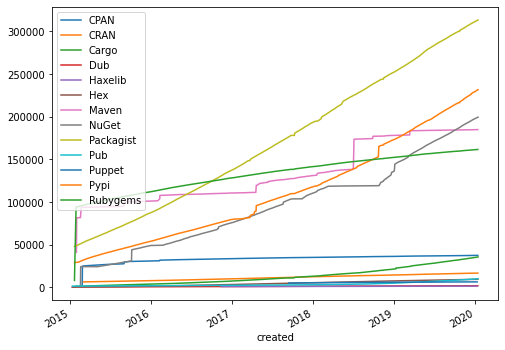

In [20]:
fig, ax = plt.subplots(figsize=(8,6))

count=1
for platform, df in df_to_plot.groupby('platform'):
    if(count < 14):
        df.plot(x='created', y='cumsum', ax=ax, label=platform)
        count = count + 1

plt.legend()

Analysis on versions

In [11]:
column_names_versions = ["id", "platform", "projectname", "projectid", "versionnumber", "publishedtime", "createdtime", "updatedtime"]

In [12]:
df_versions = postgresql_to_dataframe(conn, "select * from versions", column_names_versions)
df_versions.head()

,id,platform,projectname,projectid,versionnumber,publishedtime,createdtime,updatedtime
0,2,Dub,a4g,197,0.1.0,2014-12-06,2015-01-11,2015-02-17
1,6877975,Dub,ae,199,0.0.1808,2016-09-28,2016-10-01,2016-10-01
2,6909721,Dub,ae,199,0.0.1814,2016-10-05,2016-10-06,2016-10-06
3,7032704,Dub,ae,199,0.0.1829,2016-10-21,2016-10-21,2016-10-21
4,7286286,Dub,ae,199,0.0.1837,2016-11-02,2016-11-02,2016-11-02


In [23]:
df_versions["platform"].value_counts()

NPM           11400700
Maven          2799511
NuGet          2445000
Packagist      1766574
Pypi           1752769
Rubygems       1055874
CocoaPods       365782
CPAN            290847
Cargo           195011
Clojars         116945
Wordpress        99852
Hackage          98572
CRAN             94716
Atom             92148
Pub              75388
Hex              51401
Puppet           36826
Meteor           21953
PlatformIO       19228
Dub              15768
Haxelib           8760
Elm               6567
Homebrew          4467
Sublime           3166
Conda             2403
Jam               2224
Name: platform, dtype: int64

In [13]:
df_versions["publishedtime"] = pd.to_datetime(df_versions["publishedtime"])
df_versions["createdtime"] = pd.to_datetime(df_versions["createdtime"])
df_versions["updatedtime"] = pd.to_datetime(df_versions["updatedtime"])

In [14]:
final_packages = ["CPAN", "CRAN", "Cargo", "Dub", "Haxelib", "Hex", "Maven", "NuGet", "Packagist", "Pub", "Puppet", "Pypi", "Rubygems"]

In [15]:
df_versions_filtered = df_versions[df_versions['platform'].isin(final_packages)]

Now that versions have been read in, it is possible to analyse the growth of libraries in different package managers

In [29]:
df_versions_projects = pd.merge(df_versions_filtered, df_filtered, how='inner', left_on = 'projectid', right_on = 'id')

In [30]:
df_filtered_dates = df_versions_projects[(df_versions_projects['publishedtime'] > '1970-01-01')]

In [31]:
df_filtered_dates_sorted = df_filtered_dates.sort_values("publishedtime")

In [32]:
earliest_version_of_project = df_filtered_dates_sorted.groupby('projectname').head(1)

In [33]:
df_project_count_by_version = earliest_version_of_project.groupby(['platform_x', 'publishedtime']).size()

In [34]:
df_projects_by_versions_to_plot = df_project_count_by_version.groupby(level=0).cumsum().reset_index()

In [35]:
df_projects_by_versions_to_plot.columns = ['platform', 'published', 'cumsum']

In [37]:
df_filtered_dates = df_projects_by_versions_to_plot[(df_projects_by_versions_to_plot['published'] > '1999-12-31')]

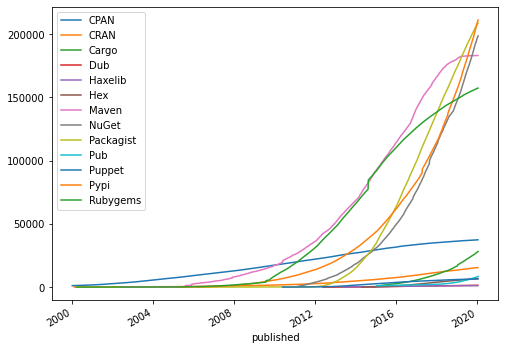

In [38]:
fig, ax = plt.subplots(figsize=(8,6))

count=1
for platform, df in df_filtered_dates.groupby('platform'):
    if(count < 14):
        df.plot(x='published', y='cumsum', ax=ax, label=platform)
        count = count + 1

plt.legend()

low_count_packages includes package managers that have few entries

In [39]:
low_count_packages = ["CPAN", "CRAN", "Cargo", "Dub", "Haxelib", "Hex", "Pub", "Puppet"]

In [40]:
df_filtered_low = df_filtered_dates[df_filtered_dates['platform'].isin(low_count_packages)]

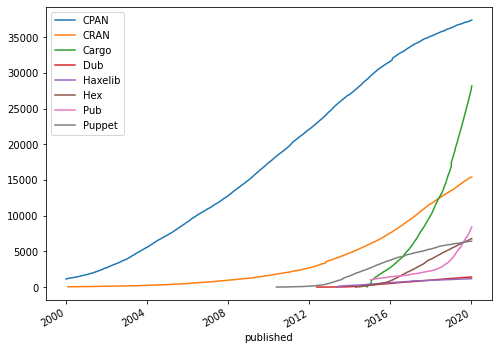

In [42]:
fig, ax = plt.subplots(figsize=(8,6))

count=1
for platform, df in df_filtered_low.groupby('platform'):
    if(count < 14):
        df.plot(x='published', y='cumsum', ax=ax, label=platform)
        count = count + 1

plt.legend()
plt.savefig('libraries_low.png')

Analysis on the growth of versions over time for each package manager

In [44]:
df_versions_count_by_platform_created = df_versions_filtered.groupby(['platform', 'publishedtime']).size()

In [45]:
df_versions_to_plot = df_versions_count_by_platform_created.groupby(level=0).cumsum().reset_index()

In [46]:
df_versions_to_plot.columns = ['platform', 'published', 'cumsum']

In [48]:
df_filtered_dates = df_versions_to_plot[(df_versions_to_plot['published'] > '1999-12-31')]

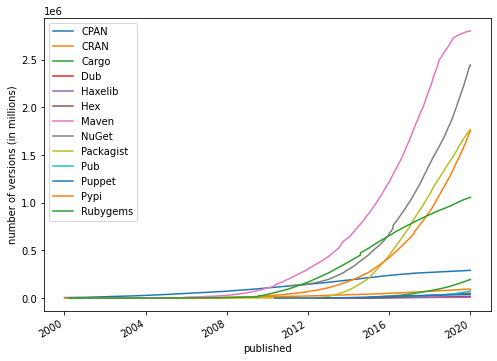

In [50]:
fig, ax = plt.subplots(figsize=(8,6))

count=1
for platform, df in df_filtered_dates.groupby('platform'):
    if(count < 14):
        df.plot(x='published', y='cumsum', ax=ax, label=platform)
        count = count + 1

ax.set_ylabel("number of versions (in millions)")
plt.legend()

In [51]:
low_count_packages = ["CPAN", "CRAN", "Cargo", "Dub", "Haxelib", "Hex", "Pub", "Puppet"]

In [52]:
df_filtered_low = df_versions_to_plot[df_versions_to_plot['platform'].isin(low_count_packages)]

In [55]:
df_filtered_dates = df_filtered_low[(df_filtered_low['published'] > '1999-12-31')]

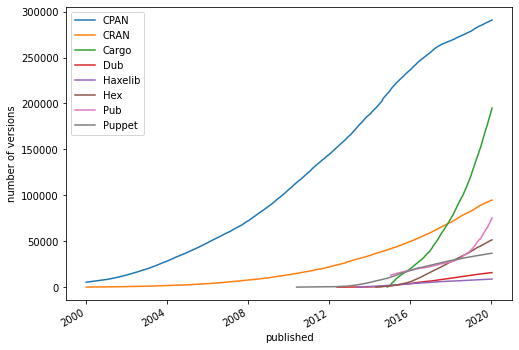

In [56]:
fig, ax = plt.subplots(figsize=(8,6))

count=1
for platform, df in df_filtered_dates.groupby('platform'):
    if(count < 14):
        df.plot(x='published', y='cumsum', ax=ax, label=platform)
        count = count + 1

ax.set_ylabel("number of versions")
plt.legend()

Analysis on the monthly uploads of new versions for each package manager

In [57]:
df_versions_rest_index = df_versions_count_by_platform_created.reset_index()

In [58]:
df_versions_rest_index.columns = ['platform', 'published', 'count']

In [59]:
grouped_by_month_versions = df_versions_rest_index.groupby("platform").resample('M', on="published").sum()

In [61]:
grouped_by_month_versions.reset_index()

,platform,published,count
0,CPAN,1995-08-31,24
1,CPAN,1995-09-30,10
2,CPAN,1995-10-31,14
3,CPAN,1995-11-30,22
4,CPAN,1995-12-31,22
...,...,...,...
4463,Rubygems,2019-09-30,6464
4464,Rubygems,2019-10-31,6717
4465,Rubygems,2019-11-30,6615
4466,Rubygems,2019-12-31,6127


In [62]:
df_filtered_dates = grouped_by_month_versions.reset_index()[(grouped_by_month_versions.reset_index()['published'] > '2005-01-01')]

In [64]:
df_filtered_dates_without_final_date = df_filtered_dates[(df_filtered_dates['published'] < '2020-01-31')]

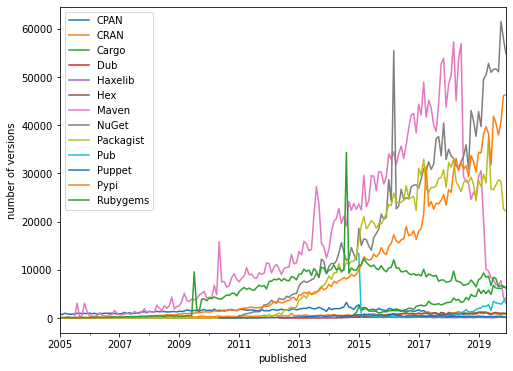

In [65]:
fig, ax = plt.subplots(figsize=(8,6))

count=1
for platform, df in df_filtered_dates_without_final_date.groupby('platform'):
    if(count < 14):
        df.plot(x='published', y='count', ax=ax, label=platform)
        count = count + 1

ax.set_ylabel("number of versions")
plt.legend()

In [66]:
low_count_versions = ["CPAN", "CRAN", "Cargo", "Dub", "Haxelib", "Hex", "Pub", "Puppet"]

In [67]:
df_filtered_low = df_filtered_dates_without_final_date[df_filtered_dates_without_final_date['platform'].isin(low_count_versions)]

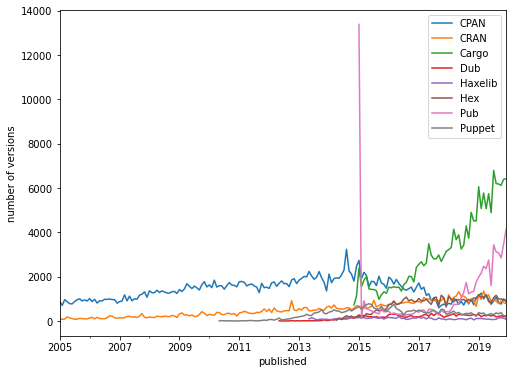

In [69]:
fig, ax = plt.subplots(figsize=(8,6))

count=1
for platform, df in df_filtered_low.groupby('platform'):
    if(count < 14):
        df.plot(x='published', y='count', ax=ax, label=platform)
        count = count + 1

ax.set_ylabel("number of versions")
plt.legend()

Analysis on dependencies

In [6]:
column_names_deps = ["id", "platform", "projectname", "projectid", "versionnumber", "versionid", "dependencyname", "dependencyplatform", "dependencykind", "optionaldependency", "dependencyrequirements", "dependencyprojectid"]

In [7]:
first_date = datetime.datetime(2000, 1, 1)

In [16]:
df_versions_filtered_dates = df_versions_filtered[(df_versions_filtered['publishedtime'] > "1970-01-01")].sort_values(by='publishedtime')

In [17]:
def get_Sum(first_date, package_manager, versions, deps):
    result = pd.DataFrame(columns=['date', 'total deps'])
    filtered_package_managers = versions.loc[versions['platform'] == package_manager]
    for i in range(241): #240 months from 01-01-2000 to 01-01-2020
        date = first_date + relativedelta(months=+i) # date
        filtered_for_date = filtered_package_managers[(filtered_package_managers['publishedtime'] < date)] # should it be "<= ?
        final_versions = filtered_for_date.groupby('projectid').tail(1)
        merged_with_deps = pd.merge(final_versions, deps, how='inner', left_on = 'id', right_on = 'versionid')
        result = result.append({'date': date,'total deps': merged_with_deps.shape[0]}, ignore_index=True)
    return result

In [34]:
df_dep_CPAN = postgresql_to_dataframe(conn, "select * from dependencies where platform='CPAN' ", column_names_deps)
df_dep_CPAN.head()

,id,platform,projectname,projectid,versionnumber,versionid,dependencyname,dependencyplatform,dependencykind,optionaldependency,dependencyrequirements,dependencyprojectid
0,31867017,CPAN,MooseX-amine,658078,0.1,7431724,Test-More,CPAN,test,False,0,NaN
1,31867020,CPAN,MooseX-amine,658078,0.1,7431724,File-Temp,CPAN,test,False,0,661485.0
2,31867021,CPAN,MooseX-amine,658078,0.1,7431724,PPI,CPAN,runtime,False,0,956674.0
3,31867022,CPAN,MooseX-amine,658078,0.1,7431724,Moose-Meta-Role,CPAN,runtime,False,0,NaN
4,31867023,CPAN,MooseX-amine,658078,0.1,7431724,Moose-Util-TypeConstraints,CPAN,runtime,False,0,NaN


In [35]:
df_dep_CPAN_filtered = df_dep_CPAN[df_dep_CPAN['dependencyprojectid'].notnull()]

In [36]:
total_deps_CPAN = get_Sum(first_date, "CPAN", df_versions_filtered_dates, df_dep_CPAN_filtered)
total_deps_CPAN

,date,total deps
0,2000-01-01,0
1,2000-02-01,0
2,2000-03-01,0
3,2000-04-01,0
4,2000-05-01,0
...,...,...
236,2019-09-01,163593
237,2019-10-01,163015
238,2019-11-01,162590
239,2019-12-01,162114


In [37]:
total_deps_CPAN.insert(loc=0, column='platform', value="CPAN")

In [46]:
df_dep_CRAN = postgresql_to_dataframe(conn, "select * from dependencies where platform='CRAN' ", column_names_deps)
df_dep_CRAN.head()

,id,platform,projectname,projectid,versionnumber,versionid,dependencyname,dependencyplatform,dependencykind,optionaldependency,dependencyrequirements,dependencyprojectid
0,128464924,CRAN,epiGWAS,3468011,1.0.1,19223584,testthat,CRAN,suggests,False,*,689434.0
1,128464925,CRAN,epiGWAS,3468011,1.0.1,19223584,knitr,CRAN,suggests,False,*,688082.0
2,128464922,CRAN,epiGWAS,3468011,1.0.1,19223584,bigmemory,CRAN,suggests,False,*,691672.0
3,128464923,CRAN,epiGWAS,3468011,1.0.1,19223584,biglasso,CRAN,suggests,False,*,1220661.0
4,128464916,CRAN,epiGWAS,3468011,1.0.1,19223584,SNPknock,CRAN,imports,False,*,2541902.0


In [47]:
df_dep_CRAN_filtered = df_dep_CRAN[df_dep_CRAN['dependencyprojectid'].notnull()]

In [48]:
total_deps_CRAN = get_Sum(first_date, "CRAN", df_versions_filtered_dates, df_dep_CRAN_filtered)
total_deps_CRAN

,date,total deps
0,2000-01-01,3
1,2000-02-01,3
2,2000-03-01,4
3,2000-04-01,4
4,2000-05-01,5
...,...,...
236,2019-09-01,76655
237,2019-10-01,77631
238,2019-11-01,79380
239,2019-12-01,80499


In [49]:
total_deps_CRAN.insert(loc=0, column='platform', value="CRAN")

In [38]:
df_dep_Cargo = postgresql_to_dataframe(conn, "select * from dependencies where platform='Cargo' ", column_names_deps)
df_dep_Cargo.head()

,id,platform,projectname,projectid,versionnumber,versionid,dependencyname,dependencyplatform,dependencykind,optionaldependency,dependencyrequirements,dependencyprojectid
0,7,Cargo,acacia,30742,0.0.1,18734,nalgebra,Cargo,runtime,False,~0.1.0,31187.0
1,8,Cargo,acacia,30742,0.0.1,18734,quickcheck,Cargo,runtime,False,~0.1.5,31296.0
2,6,Cargo,acacia,30742,0.0.1,18734,quickcheck_macros,Cargo,runtime,False,~0.1.5,31295.0
3,1,Cargo,acacia,30742,0.0.2,423307,quickcheck,Cargo,dev,False,*,31296.0
4,2,Cargo,acacia,30742,0.0.2,423307,nalgebra,Cargo,dev,False,*,31187.0


In [39]:
df_dep_Cargo_filtered = df_dep_Cargo[df_dep_Cargo['dependencyprojectid'].notnull()]

In [40]:
total_deps_Cargo = get_Sum(first_date, "Cargo", df_versions_filtered_dates, df_dep_Cargo_filtered)
total_deps_Cargo

,date,total deps
0,2000-01-01,0
1,2000-02-01,0
2,2000-03-01,0
3,2000-04-01,0
4,2000-05-01,0
...,...,...
236,2019-09-01,113555
237,2019-10-01,118358
238,2019-11-01,123238
239,2019-12-01,128388


In [41]:
total_deps_Cargo.insert(loc=0, column='platform', value="Cargo")

In [50]:
df_dep_dub = postgresql_to_dataframe(conn, "select * from dependencies where platform='Dub' ", column_names_deps)
df_dep_dub.head()

,id,platform,projectname,projectid,versionnumber,versionid,dependencyname,dependencyplatform,dependencykind,optionaldependency,dependencyrequirements,dependencyprojectid
0,8737,Dub,a4g,197,0.1.0,2,a4g:client,Dub,runtime,False,*,NaN
1,8738,Dub,a4g,197,0.1.0,2,a4g:server,Dub,runtime,False,*,NaN
2,8743,Dub,ae,199,1.0.0,6,openssl,Dub,runtime,False,>=1.1.3+1.0.1g,493.0
3,8744,Dub,ae,199,1.0.1,7,openssl,Dub,runtime,True,>=1.1.3+1.0.1g,493.0
4,8752,Dub,anchovy,203,0.2.4,21,anchovy:core,Dub,runtime,False,~master,NaN


In [51]:
df_dep_Dub_filtered = df_dep_dub[df_dep_dub['dependencyprojectid'].notnull()]

In [52]:
total_deps_Dub = get_Sum(first_date, "Dub", df_versions_filtered_dates, df_dep_Dub_filtered)
total_deps_Dub

,date,total deps
0,2000-01-01,0
1,2000-02-01,0
2,2000-03-01,0
3,2000-04-01,0
4,2000-05-01,0
...,...,...
236,2019-09-01,1099
237,2019-10-01,1106
238,2019-11-01,1124
239,2019-12-01,1136


In [53]:
total_deps_Dub.insert(loc=0, column='platform', value="Dub")

In [54]:
df_dep_Haxelib = postgresql_to_dataframe(conn, "select * from dependencies where platform='Haxelib' ", column_names_deps)
df_dep_Haxelib.head()

,id,platform,projectname,projectid,versionnumber,versionid,dependencyname,dependencyplatform,dependencykind,optionaldependency,dependencyrequirements,dependencyprojectid
0,29409134,Haxelib,flixel-demos,1841433,1.1.0,7412382,flixel,Haxelib,runtime,False,*,1841414.0
1,29409063,Haxelib,flixel,1841414,3.3.11,7412220,lime,Haxelib,runtime,False,*,1841407.0
2,29409067,Haxelib,flixel,1841414,3.3.12,7412221,lime,Haxelib,runtime,False,*,1841407.0
3,29409068,Haxelib,flixel,1841414,3.3.12,7412221,openfl,Haxelib,runtime,False,*,1841406.0
4,29409070,Haxelib,flixel,1841414,3.3.2,7412211,lime,Haxelib,runtime,False,*,1841407.0


In [55]:
df_dep_Haxelib_filtered = df_dep_Haxelib[df_dep_Haxelib['dependencyprojectid'].notnull()]

In [56]:
total_deps_Haxelib = get_Sum(first_date, "Haxelib", df_versions_filtered_dates, df_dep_Haxelib_filtered)
total_deps_Haxelib

,date,total deps
0,2000-01-01,0
1,2000-02-01,0
2,2000-03-01,0
3,2000-04-01,0
4,2000-05-01,0
...,...,...
236,2019-09-01,902
237,2019-10-01,919
238,2019-11-01,926
239,2019-12-01,937


In [57]:
total_deps_Haxelib.insert(loc=0, column='platform', value="Haxelib")

In [58]:
df_dep_Hex = postgresql_to_dataframe(conn, "select * from dependencies where platform='Hex' ", column_names_deps)
df_dep_Hex.head()

,id,platform,projectname,projectid,versionnumber,versionid,dependencyname,dependencyplatform,dependencykind,optionaldependency,dependencyrequirements,dependencyprojectid
0,7064,Hex,amazon_product_advertising_client,606,0.1.0,1918,sweet_xml,Hex,runtime,False,~> 0.1,962.0
1,7065,Hex,amazon_product_advertising_client,606,0.1.0,1918,httpoison,Hex,runtime,False,~> 0.5,819.0
2,7063,Hex,amazon_product_advertising_client,606,0.1.0,1918,timex,Hex,runtime,False,~> 0.13,970.0
3,16203314,Hex,amazon_product_advertising_client,606,0.1.1,5188751,timex,Hex,runtime,False,~> 1.0,970.0
4,16203316,Hex,amazon_product_advertising_client,606,0.1.1,5188751,sweet_xml,Hex,runtime,False,~> 0.6.1,962.0


In [59]:
df_dep_Hex_filtered = df_dep_Hex[df_dep_Hex['dependencyprojectid'].notnull()]

In [60]:
total_deps_Hex = get_Sum(first_date, "Hex", df_versions_filtered_dates, df_dep_Hex_filtered)
total_deps_Hex

,date,total deps
0,2000-01-01,0
1,2000-02-01,0
2,2000-03-01,0
3,2000-04-01,0
4,2000-05-01,0
...,...,...
236,2019-09-01,12504
237,2019-10-01,12785
238,2019-11-01,13048
239,2019-12-01,13322


In [61]:
total_deps_Hex.insert(loc=0, column='platform', value="Hex")

In [26]:
df_dep_Maven = postgresql_to_dataframe(conn, "select * from dependencies where platform='Maven' ", column_names_deps)
df_dep_Maven.head()

,id,platform,projectname,projectid,versionnumber,versionid,dependencyname,dependencyplatform,dependencykind,optionaldependency,dependencyrequirements,dependencyprojectid
0,45701596,Maven,org.apache.geronimo.plugins:openjpa2,334933,2.2-beta,1272347,org.apache.geronimo.testsupport:testsupport-co...,Maven,test,False,2.2,353555.0
1,45411815,Maven,org.gebish:geb-spock,384342,0.9.0,2062799,org.gebish:geb-core,Maven,compile,False,0.9.0,383569.0
2,45701558,Maven,org.jbehave.web:jbehave-trader-webapp,334918,2.0-beta-1,1272261,org.jbehave.web:jbehave-web-waffle,Maven,runtime,False,2.0-beta-1,358067.0
3,45701577,Maven,org.apache.cxf.dosgi.systests:cxf-dosgi-ri-sys...,334924,1.0,1272312,org.apache.servicemix.kernel.testing:org.apach...,Maven,runtime,False,1.0.0,416712.0
4,45701578,Maven,org.apache.cxf.dosgi.systests:cxf-dosgi-ri-sys...,334924,1.0,1272312,org.apache.cxf.dosgi.samples:cxf-dosgi-ri-samp...,Maven,runtime,False,${project.version},388231.0


In [27]:
df_dep_Maven_filtered = df_dep_Maven[df_dep_Maven['dependencyprojectid'].notnull()]

In [28]:
total_deps_Maven = get_Sum(first_date, "Maven", df_versions_filtered_dates, df_dep_Maven_filtered)
total_deps_Maven

,date,total deps
0,2000-01-01,0
1,2000-02-01,0
2,2000-03-01,0
3,2000-04-01,0
4,2000-05-01,0
...,...,...
236,2019-09-01,434056
237,2019-10-01,435520
238,2019-11-01,436116
239,2019-12-01,436187


In [29]:
total_deps_Maven.insert(loc=0, column='platform', value="Maven")

In [30]:
df_dep_NuGet = postgresql_to_dataframe(conn, "select * from dependencies where platform='NuGet' ", column_names_deps)
df_dep_NuGet.head()

,id,platform,projectname,projectid,versionnumber,versionid,dependencyname,dependencyplatform,dependencykind,optionaldependency,dependencyrequirements,dependencyprojectid
0,10518262,NuGet,jquery.datatables,607911,1.10.2,2269197,jQuery,NuGet,runtime,False,>= 1.7.0,616252.0
1,129765553,NuGet,libc,3462820,5.4.0,19346307,FastMember,NuGet,runtime,False,>= 1.5.0,624566.0
2,10789180,NuGet,Outercurve.SQLiteParser,607903,1.1.50-prerelease,2269130,Antlr4,NuGet,runtime,False,>= 4.1.0-alpha003,628013.0
3,10789181,NuGet,Outercurve.SQLiteParser,607903,1.1.50-prerelease,2269130,Antlr4.Runtime,NuGet,runtime,False,>= 4.1.0-alpha003,612490.0
4,10789182,NuGet,Outercurve.SQLiteParser,607903,1.1.51-prerelease,2269131,Antlr4,NuGet,runtime,False,>= 4.1.0-alpha003,628013.0


In [31]:
df_dep_NuGet_filtered = df_dep_NuGet[df_dep_NuGet['dependencyprojectid'].notnull()]

In [32]:
total_deps_NuGet = get_Sum(first_date, "NuGet", df_versions_filtered_dates, df_dep_NuGet_filtered)
total_deps_NuGet

,date,total deps
0,2000-01-01,0
1,2000-02-01,0
2,2000-03-01,0
3,2000-04-01,0
4,2000-05-01,0
...,...,...
236,2019-09-01,350686
237,2019-10-01,360524
238,2019-11-01,370814
239,2019-12-01,380599


In [33]:
total_deps_NuGet.insert(loc=0, column='platform', value="NuGet")

In [18]:
df_dep_Packagist = postgresql_to_dataframe(conn, "select * from dependencies where platform='Packagist' ", column_names_deps)
df_dep_Packagist.head()

,id,platform,projectname,projectid,versionnumber,versionid,dependencyname,dependencyplatform,dependencykind,optionaldependency,dependencyrequirements,dependencyprojectid
0,4311372,Packagist,1001pharmacies/geolocation-bundle,37454,v1.0.0-beta,53859,fabpot/goutte,Packagist,runtime,False,~2.0,63416.0
1,4311366,Packagist,1001pharmacies/dictionary,37455,v0.3.1,53852,squizlabs/php_codesniffer,Packagist,Development,False,1.*,109527.0
2,4311367,Packagist,1001pharmacies/dictionary,37455,v0.3.1,53852,sebastian/phpcpd,Packagist,Development,False,2.*,107108.0
3,4311414,Packagist,10mado/silexcane,37458,1.0.0,53888,silex/silex,Packagist,runtime,False,~1.2,107753.0
4,4311415,Packagist,10mado/silexcane,37458,1.0.0,53888,vlucas/valitron,Packagist,runtime,False,>=1.1.8,114124.0


In [19]:
df_dep_Packagist_filtered = df_dep_Packagist[df_dep_Packagist['dependencyprojectid'].notnull()]

In [20]:
total_deps_Packagist = get_Sum(first_date, "Packagist", df_versions_filtered_dates, df_dep_Packagist_filtered)
total_deps_Packagist

,date,total deps
0,2000-01-01,0
1,2000-02-01,0
2,2000-03-01,0
3,2000-04-01,0
4,2000-05-01,0
...,...,...
236,2019-09-01,612701
237,2019-10-01,621583
238,2019-11-01,630698
239,2019-12-01,638503


In [21]:
total_deps_Packagist.insert(loc=0, column='platform', value="Packagist")

In [62]:
df_dep_Pub = postgresql_to_dataframe(conn, "select * from dependencies where platform='Pub' ", column_names_deps)
df_dep_Pub.head()

,id,platform,projectname,projectid,versionnumber,versionid,dependencyname,dependencyplatform,dependencykind,optionaldependency,dependencyrequirements,dependencyprojectid
0,36151859,Pub,Bomberman,29192,1.0.0,5289,browser,Pub,runtime,False,>=0.10.0+1 <0.10.1,29311.0
1,36151860,Pub,ChronosGL,29193,1.0.0,5290,browser,Pub,runtime,False,any,29311.0
2,36151861,Pub,ChronosGL,29193,1.0.1,5291,browser,Pub,runtime,False,any,29311.0
3,36151862,Pub,ChronosGL,29193,1.0.2,5292,browser,Pub,runtime,False,any,29311.0
4,36151863,Pub,ChronosGL,29193,1.0.3,5293,browser,Pub,runtime,False,any,29311.0


In [63]:
df_dep_Pub_filtered = df_dep_Pub[df_dep_Pub['dependencyprojectid'].notnull()]

In [64]:
total_deps_Pub = get_Sum(first_date, "Pub", df_versions_filtered_dates, df_dep_Pub_filtered)
total_deps_Pub

,date,total deps
0,2000-01-01,0
1,2000-02-01,0
2,2000-03-01,0
3,2000-04-01,0
4,2000-05-01,0
...,...,...
236,2019-09-01,22123
237,2019-10-01,23349
238,2019-11-01,24366
239,2019-12-01,25744


In [65]:
total_deps_Pub.insert(loc=0, column='platform', value="Pub")

In [66]:
df_dep_Puppet = postgresql_to_dataframe(conn, "select * from dependencies where platform='Puppet' ", column_names_deps)
df_dep_Puppet.head()

,id,platform,projectname,projectid,versionnumber,versionid,dependencyname,dependencyplatform,dependencykind,optionaldependency,dependencyrequirements,dependencyprojectid
0,94749649,Puppet,puppetlabs-puppetdb,2429950,5.1.0,15091591,puppetlabs-postgresql,Puppet,runtime,False,>= 4.0.0 <5.0.0,2429984.0
1,88296265,Puppet,puppetlabs-puppetdb,2429950,1.0.0,15091649,cprice404-inifile,Puppet,runtime,False,0.0.x,2430433.0
2,88296274,Puppet,puppetlabs-puppetdb,2429950,1.0.0,15091649,puppetlabs-firewall,Puppet,runtime,False,0.0.x,2429988.0
3,88296269,Puppet,puppetlabs-puppetdb,2429950,1.0.0,15091649,inkling-postgresql,Puppet,runtime,False,0.3.x,2431373.0
4,88296281,Puppet,puppetlabs-puppetdb,2429950,1.0.1,15091646,inkling-postgresql,Puppet,runtime,False,0.3.x,2431373.0


In [67]:
df_dep_Puppet_filtered = df_dep_Puppet[df_dep_Puppet['dependencyprojectid'].notnull()]

In [68]:
total_deps_Puppet = get_Sum(first_date, "Puppet", df_versions_filtered_dates, df_dep_Puppet_filtered)
total_deps_Puppet

,date,total deps
0,2000-01-01,0
1,2000-02-01,0
2,2000-03-01,0
3,2000-04-01,0
4,2000-05-01,0
...,...,...
236,2019-09-01,9062
237,2019-10-01,9128
238,2019-11-01,9186
239,2019-12-01,9216


In [69]:
total_deps_Puppet.insert(loc=0, column='platform', value="Puppet")

In [42]:
df_dep_Pypi = postgresql_to_dataframe(conn, "select * from dependencies where platform='Pypi' ", column_names_deps)
df_dep_Pypi.head()

,id,platform,projectname,projectid,versionnumber,versionid,dependencyname,dependencyplatform,dependencykind,optionaldependency,dependencyrequirements,dependencyprojectid
0,34998552,Pypi,1pass,31613,0.1.2,22218,simple-pbkdf2,Pypi,runtime,False,*,NaN
1,34998553,Pypi,1pass,31613,0.1.2,22218,pycrypto,Pypi,runtime,False,*,68140.0
2,34998554,Pypi,1pass,31613,0.1.3,22220,simple-pbkdf2,Pypi,runtime,False,*,NaN
3,34998555,Pypi,1pass,31613,0.1.3,22220,PyCrypto,Pypi,runtime,False,*,68140.0
4,34998556,Pypi,1pass,31613,0.1.5,22223,simple-pbkdf2,Pypi,runtime,False,*,NaN


In [43]:
df_dep_Pypi_filtered = df_dep_Pypi[df_dep_Pypi['dependencyprojectid'].notnull()]

In [44]:
total_deps_Pypi = get_Sum(first_date, "Pypi", df_versions_filtered_dates, df_dep_Pypi_filtered)
total_deps_Pypi

,date,total deps
0,2000-01-01,0
1,2000-02-01,0
2,2000-03-01,0
3,2000-04-01,0
4,2000-05-01,0
...,...,...
236,2019-09-01,69875
237,2019-10-01,72620
238,2019-11-01,72296
239,2019-12-01,71016


In [45]:
total_deps_Pypi.insert(loc=0, column='platform', value="Pypi")

In [22]:
df_dep_Rubygems = postgresql_to_dataframe(conn, "select * from dependencies where platform='Rubygems' ", column_names_deps)
df_dep_Rubygems.head()

,id,platform,projectname,projectid,versionnumber,versionid,dependencyname,dependencyplatform,dependencykind,optionaldependency,dependencyrequirements,dependencyprojectid
0,8775173,Rubygems,perkins,428861,0.0.5,3391126,haml,Rubygems,runtime,False,>= 0,208464.0
1,29517150,Rubygems,4info,40902,1.2.2,66944,hpricot,Rubygems,runtime,False,>= 0,210795.0
2,29517149,Rubygems,4info,40902,1.2.2,66944,haml,Rubygems,runtime,False,>= 0,208464.0
3,29518126,Rubygems,aasm,41203,4.0.0,68212,sdoc,Rubygems,Development,False,>= 0,249096.0
4,6487442,Rubygems,abongo,41575,1.0.8,69650,rake,Rubygems,Development,False,>= 0,239884.0


In [23]:
df_dep_Rubygems_filtered = df_dep_Rubygems[df_dep_Rubygems['dependencyprojectid'].notnull()]

In [24]:
total_deps_Rubygems = get_Sum(first_date, "Rubygems", df_versions_filtered_dates, df_dep_Rubygems_filtered)
total_deps_Rubygems

,date,total deps
0,2000-01-01,0
1,2000-02-01,0
2,2000-03-01,0
3,2000-04-01,0
4,2000-05-01,0
...,...,...
236,2019-09-01,605636
237,2019-10-01,608708
238,2019-11-01,612036
239,2019-12-01,615370


In [25]:
total_deps_Rubygems.insert(loc=0, column='platform', value="Rubygems")

In [70]:
frames = [total_deps_CPAN, total_deps_CRAN, total_deps_Cargo, total_deps_Dub, total_deps_Haxelib, total_deps_Hex, total_deps_Maven, total_deps_NuGet, total_deps_Packagist, total_deps_Pub, total_deps_Puppet, total_deps_Pypi, total_deps_Rubygems]

In [71]:
all_deps = pd.concat(frames, ignore_index=True)

In [72]:
all_deps

,platform,date,total deps
0,CPAN,2000-01-01,0
1,CPAN,2000-02-01,0
2,CPAN,2000-03-01,0
3,CPAN,2000-04-01,0
4,CPAN,2000-05-01,0
...,...,...,...
3128,Rubygems,2019-09-01,605636
3129,Rubygems,2019-10-01,608708
3130,Rubygems,2019-11-01,612036
3131,Rubygems,2019-12-01,615370


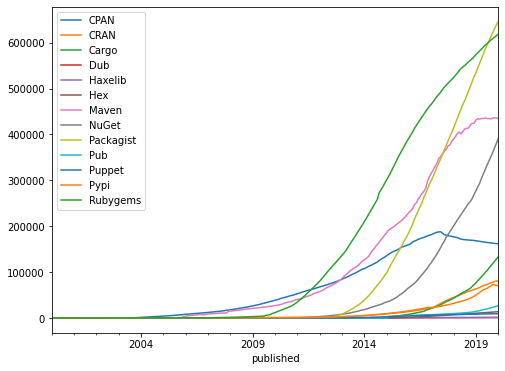

In [78]:
fig, ax = plt.subplots(figsize=(8,6))

count=1
for platform, df in all_deps.groupby('platform'):
    if(count < 14):
        df.plot(x='date', y='total deps', ax=ax, label=platform)
        count = count + 1

ax.set_xlabel("published")
plt.legend()
plt.savefig('deps.png')

In [74]:
low_count_deps = ["CRAN", "Cargo", "Dub", "Haxelib", "Hex", "Pub", "Puppet", "Pypi"]

In [75]:
df_filtered_low = all_deps[all_deps['platform'].isin(low_count_deps)]

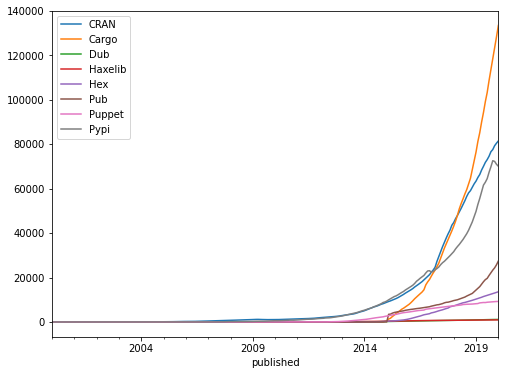

In [79]:
fig, ax = plt.subplots(figsize=(8,6))

count=1
for platform, df in df_filtered_low.groupby('platform'):
    if(count < 14):
        df.plot(x='date', y='total deps', ax=ax, label=platform)
        count = count + 1

ax.set_xlabel("published")
plt.legend()
plt.savefig('deps_low.png')